# Assignment 6 - Object recognition in images with deep learning

## Goals

In this assignment you will get to know the main ingredients of deep learning and get to use the GPUs available in the Big Data Lab.

You'll learn to use

 * tensors and automatic differentiation
 * layered models
 * p(re)trained networks for image classification.

## Check the GPU setup

When you are logged in to a lab machine, run ``nvidia-smi`` to see the available card and its memory usage.

```
$ nvidia-smi
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   24C    P8    N/A /  75W |   3087MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      3627      G   /usr/lib/xorg/Xorg                           169MiB |
|    0     10843      C   ...d/CMPT/big-data/tmp_py/dlenv/bin/python  2897MiB |
+-----------------------------------------------------------------------------+
```

This shows that the machine has an **NVIDIA GTX 1050 with 4G of RAM**. Also, you can see that it is running a process (pid=10843) that currently takes up close to 3 GB of GPU memory. On our current `blu9402` lab machines you will notice a difference, as they have 8GB of RAM.

```
$ pstree -ls 10843
screen───bash───jupyter-noteboo───python─┬─4*[python]
                                         └─26*[{python}]
```
Inside a terminal window you may use ``who``, ``ps -aux | less``, or ``pstree -ls <PID>`` as above to find out who is using the shared resources. In my case, it turns out that I'm running a jupyter notebook related to process 10843. Halting the notebook frees up the GPU memory. 

## PyTorch setup in the lab

To build deep learning models in this assignment we are using **[PyTorch](http://pytorch.org)**, a replacement for numpy that provides accelerated computation on the GPU, automatic differentiation, and various utilities to train and deploy neural networks. Its popularity relative to [tensorflow](http://tensorflow.org) has been steadily increasing and it also has a high-level API, the [NN module](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) similar to [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras).

In case you have trouble configuring a conda environment that has a CUDA version of pytorch installed, you could use the one that's provided under the prefix  
`conda activate /usr/shared/CMPT/big-data/condaenv/nn11`

### Save disk space in the lab: Use shared downloaded pre-built models
To save disk space in your home folder, we recommend that you let pytorch use the pre-built models that we already downloaded for you (about 1.9G):
```
mkdir -p ~/.cache/torch/hub/checkpoints
ln -s /usr/shared/CMPT/big-data/dot_torch_shared/checkpoints/* ~/.cache/torch/hub/checkpoints
```

## Learn about Pytorch usage

To familiarize yourself with PyTorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html) on Tensors, or the NN module, or briefly skim over the [60 min blitz tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

# Task 1: Finding rectangles

A nice [**blog-post** by Johannes Rieke](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) presents a simple setup from scratch that finds rectangles in a black & white image. In order to play with it, we just have to translate a few calls from Keras to PyTorch.

To familiarize yourself with using pytorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html). The following code is preparing our training setup.

In [601]:
# to check GPU memory, uncomment and run the following line
#!{'nvidia-smi'}

The training data consists of $50,000$ example images.  
`imgs` is an array of shape (50000, 8, 8), giving an $8\times8$ pixel image for each example.  
`bboxes` is an array of shape (50000, 1, 4), giving a $1\times4$ row vector [x, y, w, h] for each rectangle.

**Here is an example of the training data:**

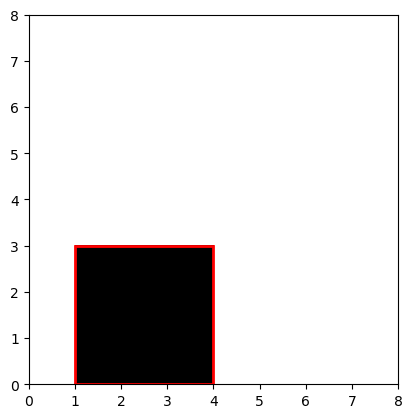

In [602]:
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib

# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]

display(Markdown(f"The training data consists of ${num_imgs:,}$ example images.  \n"
                 f"`imgs` is an array of shape {imgs.shape}, giving an ${img_size}\\times{img_size}$ pixel image for each example.  \n"
                 f"`bboxes` is an array of shape {bboxes.shape}, giving a $1\\times4$ row vector [x, y, w, h] for each rectangle."
                ))
display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none', lw=2))

In [603]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
display(Markdown(f"New shape of `imgs`: {X.shape}, with normalized mean {np.mean(X):.2f} and stdev {np.std(X):.2f}"))

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

New shape of `imgs`: (50000, 64), with normalized mean -0.00 and stdev 1.00

## Task 1a
**Construct a Pytorch model that resembles the Keras one in the original blog post**, i.e. have a fully connected, hidden layer with 200 neurons, ReLU nonlinearity and dropout rate of 20%.

In [1017]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64, 200),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Linear(200, 4),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

Using mps device


In [1018]:
# Instantiate the adadelta optimizer with the models parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # You can adjust the learning rate and other parameters as needed. # AdamW ~ .5, Adam ~ .49, Adagrad ~ 0.63, Adamax ~ .49, ASGD ~ nan, 
# Instantiate the loss function as MSE
# Sum the losses over all instances in the batch, rather than averaged.
loss_fn = torch.nn.MSELoss(reduction='sum')

In [1019]:
# Prepare train data for testing
inputs = torch.Tensor(train_X).to(device)
labels = torch.Tensor(train_y).to(device)

# Prepare test data for evaluation
inputs_test = torch.Tensor(test_X).to(device)
labels_test = torch.Tensor(test_y).to(device)

In [1020]:
phase = 'train'
model.train()
do_test_loss = False

loss_record = []
loss_test_record = []
for epoch in range(200):     # 30 Epochs (passes through the training dataset) of training
    optimizer.zero_grad()   # Clear old gradients from the last step (or the initial step) before the loss calculation of the current step.
    outputs = model(inputs) # Feed the input tensor through the model to obtain predictions (outputs)
    loss = loss_fn(outputs, labels) # Computes the loss by comparing the model's predictions (outputs) against the true labels using the loss function
    loss_record.append(loss.item()) # Record the current loss value. Using .item() converts the tensor to a Python number

    if phase == 'train':
        loss.backward()     # Calculate the gradient of the loss function with respect to the model parameters
        optimizer.step()    # Update the model's parameters based on the gradients computed by .backward()
    
    if do_test_loss:
        with torch.no_grad():
            outputs_test = model(inputs_test)
            loss_test = loss_fn(outputs_test, labels_test)
            loss_test_record.append(loss_test.item())

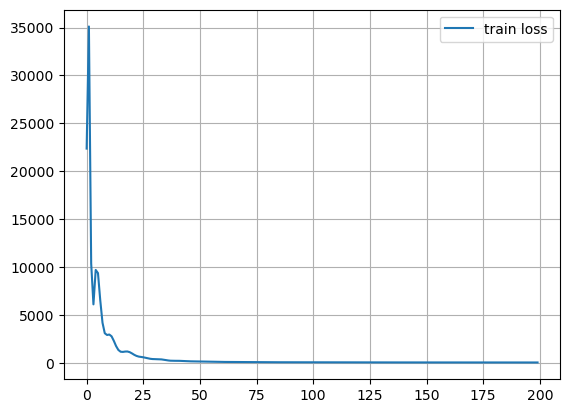

In [1021]:
plt.plot(loss_record)
if do_test_loss:
    plt.plot(loss_test_record)
    plt.legend(["train loss", "test loss"])
else:
    plt.legend(["train loss"])
plt.grid(True)

**Change the model from training to evaluation mode** to improve testing performance.

In [1022]:
phase = 'test'
# TODO
# ...
# Put the model into eval mode
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=64, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=200, out_features=4, bias=True)
  )
)

In [1023]:
# Convert test_X to a tensor, if not already, and send it to the same device as the model
test_X_tensor = torch.Tensor(test_X).to(device)

# Predict bounding boxes on the test images
with torch.no_grad():  # Disable gradient calculation for inference
    pred_y = model(test_X_tensor)

# Scale the predictions back to the image size
pred_bboxes = pred_y.cpu().numpy() * img_size  # Move data back to CPU if necessary and convert to numpy
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)

# Output the shape of the predicted bounding boxes
pred_bboxes.shape


(10000, 1, 4)

In [1024]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.9425920254345354

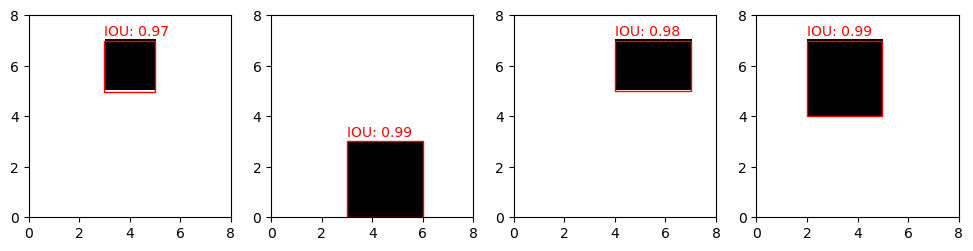

In [1025]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

## Task 1b:
Move the computation that is currently done on the CPU over to the GPU using CUDA and increase the number of epochs.  **Improve the training setup**, possibly also changing model or optimizer, until you **reach a test IOU above 0.9**.

You can make the changes that move computation to the GPU directly in the cells above as part of 1a.

You may get stuck not achieving test IOU above 0.6. In that case, learn about switching the model to evaluation mode and apply the change above.

## Question 1c:
Why does `eval` mode above have such a significant effect on test performance? Please give a short answer below.

In .train() mode there are certain layers in our model, such as Dropout (useful for preventing overfitting) and BatchNorm (normalizes the input using the batch statistics) layers, that will behave according to how we specify them. We use this mode during training because they help to train and generalize the model.

In .eval() mode, the behaviour of these layers are altered that are appropriate for evaluation but not training. For example, Dropout layers are eliminated (no elements are dropped) since this is only useful for generalization during training, and BatchNorm layers use running estimates that were calculated during training, ensuring that the model's inference is not affected by the batch size.

Since in .eval() mode these changes are implemented, in particular the elimination of the dropout layer means that we will naturally see a spike in the accuracy of the output since the model is not being artificially throttled.

# Task 2: Use a pretrained model

As mentioned in class, deep learning systems are hardly ever developed from scratch, but usually work by refining existing solutions to similar problems. For the following task, we'll **work through the 
[Transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)**, which also provides a ready-made jupyter notebook.

 **2.1.** Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.  
 **2.2.** Perform your own training with the provided setup, fill out the answer to Task 2.2 below.  
 **2.3.** Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type and use the "conv net as fixed feature extractor" approach, fill out the answer to Task 2.3 below.  
 **2.4.** Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network) that can detect one out of 1000 classes. Fill out the answer to Task 2.4 below.

## Your solution for Task 2

Before you start, get the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it into a subfolder `data`. The following import is going to attempt loading the image data from there.

Initialize much of the source code from the tutorial notebook located at
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
using [this module](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/tfl_tut.py)

In [6]:
from tfl_tut import *

Please study the original notebook and then continue to use its functions as imported from the `tfl_tut` model for convenience to minimize source code copy & paste.

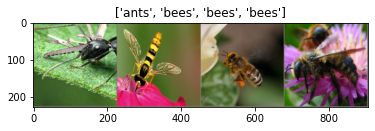

In [7]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
model_conv = models.inception_v3(pretrained=True)

### Answer for Task 2.2

In [9]:
# TODO paste and maybe modify relevant code to perform your own training

In [ ]:
visualize_model(model_ft)

### Answer for Task 2.3

### Hints for this task

Focus on the section **Conv net as fixed feature xtractor** of the transfer learning tutorial.
First, change the line
```
model_conv = models.resnet18(pretrained=True)
```
to load VGG16 instead. Set all its parameters to *not* require gradient computation, as shown in the tutorial.

Next, print out the new `model_conv` and identify the last step of the classification. This is not named the same way as the ```fc``` layer for resnet, but it works similarily. The last classification step of the VGG model determines the probabilities for each of the 1000 classes of the dataset. Change this layer to identify only 2 classes to distinguish ants and bees as in the example.

To change the structure of some `Sequential` component called ```model_conv.module_name``` and to modify its last layer into a `DifferentLayer` type, you can use this syntax:

```
nn.Sequential(*list(model_conv.module_name.children())[:-1] +
                     [nn.DifferentLayer(...)])
```
and replace the old `model_conv.module_name` with this differently structured version.

In [ ]:
# TODO

### Answer for Task 2.4

In [11]:
# TODO

Please include the picture so we can view it and its class label in the saved notebook. It's OK, if we don't have the actual image file to reproduce the output.

## Submission

Your submission should be based on a modified version of [this notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/A6.ipynb) containing answers to Task 1 and for Task 2, saved with figures including some portions of the transfer learning tutorial notebook in the sections for tasks 2.1 - 2.4.